In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%ls -ltrh /Users/laurentperrinet/quantic/grants/Polychronies/RSG-spikepatterns/Data/

total 2267760
-rw-r--r--  1 laurentperrinet  staff   211M Jun 14 10:42 H_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--  1 laurentperrinet  staff   407M Jun 14 10:55 G_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--@ 1 laurentperrinet  staff   2.0K Jun 15 12:29 README.md
-rw-r--r--@ 1 laurentperrinet  staff   183M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff   212M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=1.npz
-rw-r--r--@ 1 laurentperrinet  staff    17M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff    68M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=1.npz


In [3]:
i_session = 0
monkey = 'G'
from pathlib import Path
path = Path.home()/'quantic'/'grants'/'polychronies'/'RSG-spikepatterns'/'Data'/f'{monkey}_Ready-Set_bin1ms_alignedReady_session={i_session}.npz'

dictdata = np.load(path)
data, id_neuron, id_short, t_s, t_p = dictdata['data'], dictdata['id_neuron'], dictdata['id_short'], dictdata['t_s'], dictdata['t_p']
data = data.astype(float)
data[data==255] = np.nan
N_time, N_neuron, N_trial = data.shape

N_time, N_neuron, N_trial

(1200, 107, 1498)

### computing the firing rates

In [4]:
t_s_max = int(t_s.max())
DeltaT = 100 # number of time bins on which we average
dt = 40 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, t_s_max+1, dt)
N_timepoint = len(timepoints)
timepoints, N_timepoint

(array([ 100,  140,  180,  220,  260,  300,  340,  380,  420,  460,  500,
         540,  580,  620,  660,  700,  740,  780,  820,  860,  900,  940,
         980, 1020, 1060, 1100, 1140, 1180]),
 28)

In [5]:
fr = np.empty((N_timepoint, N_neuron, N_trial)) * np.nan
for i_timepoint, timepoint in enumerate(timepoints):
    fr[i_timepoint, :, :] = np.nansum(data[(timepoint-DeltaT):timepoint, :, :], axis=0) / (DeltaT/1000)

In [6]:
# for i_trial in range(N_trial):
#     print(i_trial, torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum())
#     break
# torch.isnan(torch.tensor(fr.astype(float))).sum(), torch.isnan(torch.tensor(data.astype(float))).sum()

In [7]:
fr.shape

(28, 107, 1498)

In [8]:
ratio_train = 80/100
N_trial_train = int(N_trial*ratio_train)
N_trial_test = N_trial - N_trial_train
idx_trial = np.random.permutation(N_trial)
idx_trial

array([783, 418,  15, ..., 539, 858, 573])

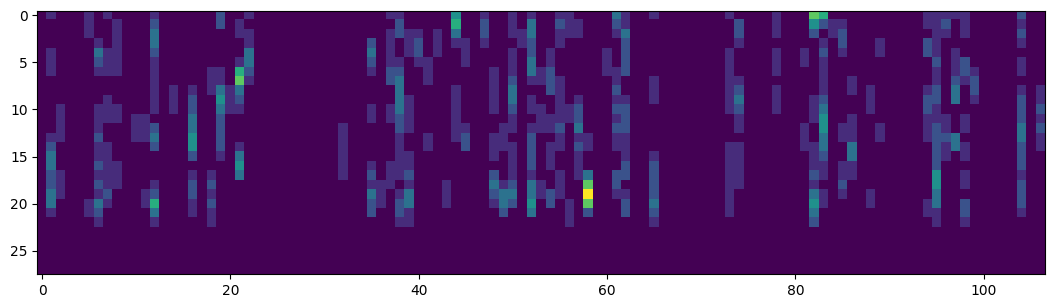

In [9]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(fr[:, :, 102], cmap='viridis')

### logistic regression model with NaNs

### inference model

In [10]:
import torch
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

device = 'cpu'

In [11]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# torch.set_default_tensor_type("torch.FloatTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size


class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N_neuron, N_timepoint, logit_0=-2., logit_wt=0.1):
        super(LogisticRegressionModel, self).__init__() 
        self.bias = torch.nn.Parameter(logit_0*torch.ones(1, N_timepoint))
        self.weight = torch.nn.Parameter(logit_wt * torch.randn((N_neuron, N_timepoint)))
        # self.nl = torch.nn.Softmax(N_timepoint)
        # self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_neuron
        X_input[torch.isnan(X_input)] = 0.
        # return self.nl(X_input @ self.weight +  self.bias)
        # print(X_input.dtype, self.bias.dtype, self.weight.dtype)
        return F.softmax(torch.tensordot(X_input, self.weight, dims=1) +  self.bias, dim=1)

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [12]:
# F.softmax?
# torch.tensor?

In [13]:
logistic_model = LogisticRegressionModel(N_neuron, N_timepoint)
i_trial = 3
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
outputs = logistic_model(X)
X.shape, outputs.shape

(torch.Size([28, 107]), torch.Size([28, 28]))

In [14]:
X.sum(axis=1), (X.sum(axis=1)>0).shape

(tensor([480., 490., 440., 370., 390., 520., 610., 490., 410., 440., 420., 460.,
         480., 530., 500., 430., 480., 470., 410., 480., 540., 350., 100.,   0.,
           0.,   0.,   0.,   0.]),
 torch.Size([28]))

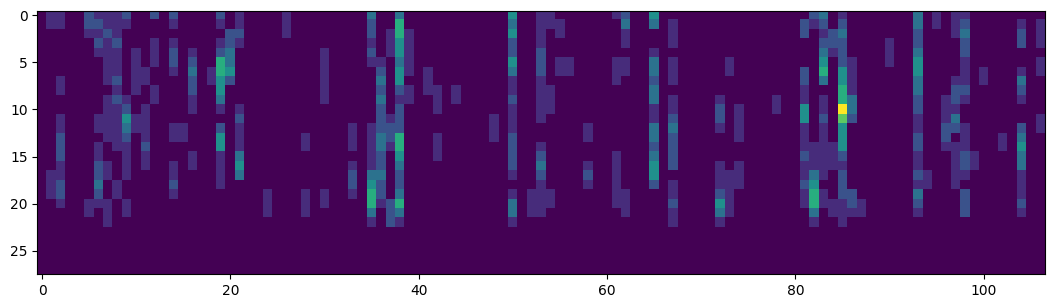

In [15]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(X.numpy(), cmap='viridis')

In [16]:
N_timepoint, np.arange(N_timepoint),  np.arange(N_timepoint)[X.sum(axis=1)>0]


(28,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]))

In [17]:
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
X = X[time_labels, :]
outputs = logistic_model(X)
time_labels, X.shape, outputs.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 torch.Size([23, 107]),
 torch.Size([23, 28]))

In [18]:
F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

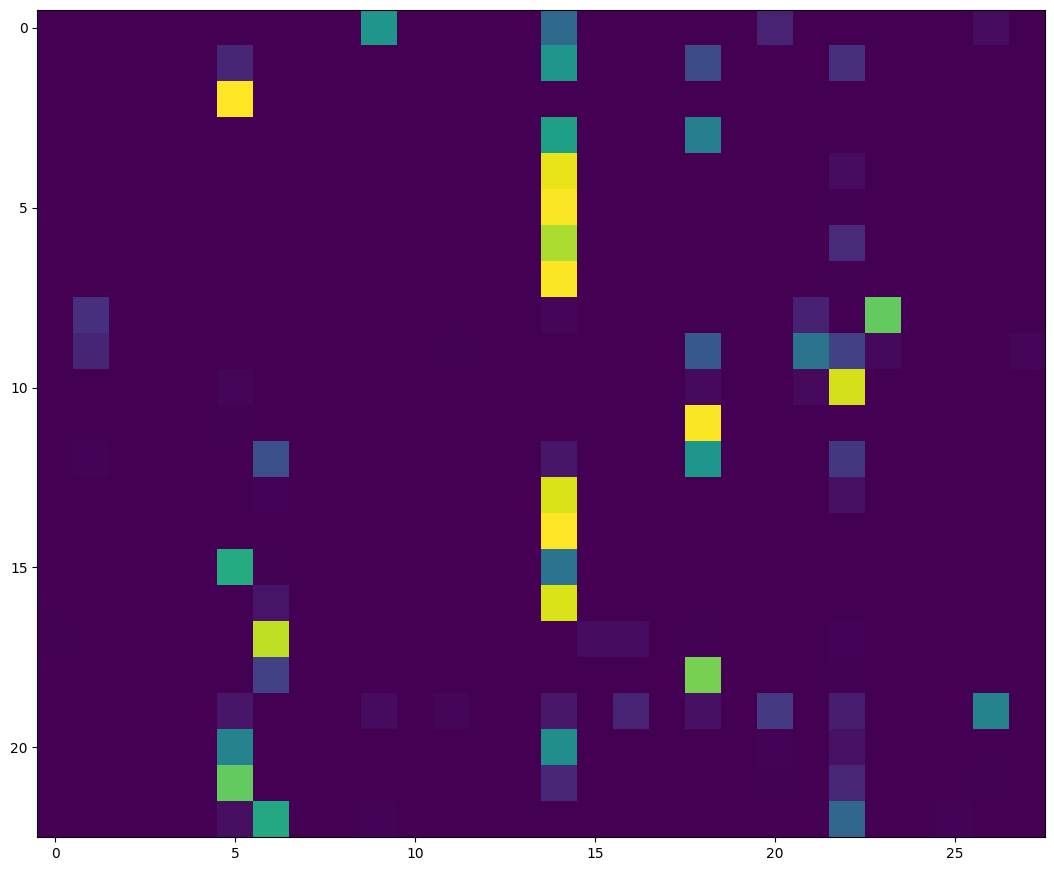

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs.detach().numpy(), cmap='viridis')

In [20]:
learning_rate = 0.00005
logit_0 = -2.
logit_wt = 0.1
beta1, beta2 = 0.995, 0.999
num_epochs = 2 ** 10 + 1
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(fr, logit_0=logit_0, logit_wt=0.1,
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                beta1=beta1, beta2=beta2, amsgrad=amsgrad,
                verbose=False, 
        ):

    logistic_model = LogisticRegressionModel(N_neuron, N_timepoint, logit_0=logit_0, logit_wt=logit_wt)
    # logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(beta1, beta2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for i_trial in idx_trial[range(N_trial_train)]:
            X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
            time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
            X = X[time_labels, :]
            labels = F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.
            # X, labels = X.to(device), labels.to(device)
            outputs = logistic_model(X)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    return logistic_model, np.mean(losses)


In [21]:

logistic_model, loss = fit_data(fr, verbose=True)

Iteration: 0 - Loss: 0.65640
Iteration: 32 - Loss: 0.13167
Iteration: 64 - Loss: 0.13023
Iteration: 96 - Loss: 0.13010
Iteration: 128 - Loss: 0.13001
Iteration: 160 - Loss: 0.12995
Iteration: 192 - Loss: 0.12990
Iteration: 224 - Loss: 0.12986
Iteration: 256 - Loss: 0.12983
Iteration: 288 - Loss: 0.12981
Iteration: 320 - Loss: 0.12979
Iteration: 352 - Loss: 0.12978
Iteration: 384 - Loss: 0.12977
Iteration: 416 - Loss: 0.12976
Iteration: 448 - Loss: 0.12975
Iteration: 480 - Loss: 0.12974
Iteration: 512 - Loss: 0.12974
Iteration: 544 - Loss: 0.12973
Iteration: 576 - Loss: 0.12973
Iteration: 608 - Loss: 0.12973
Iteration: 640 - Loss: 0.12972
Iteration: 672 - Loss: 0.12972
Iteration: 704 - Loss: 0.12972
Iteration: 736 - Loss: 0.12972
Iteration: 768 - Loss: 0.12972
Iteration: 800 - Loss: 0.12972
Iteration: 832 - Loss: 0.12972
Iteration: 864 - Loss: 0.12971
Iteration: 896 - Loss: 0.12971
Iteration: 928 - Loss: 0.12971
Iteration: 960 - Loss: 0.12971
Iteration: 992 - Loss: 0.12971
Iteration: 10

In [22]:
logistic_model.weight.detach().numpy().shape, logistic_model.weight.detach().numpy().ravel().shape

((107, 28), (2996,))

In [23]:
with torch.no_grad():
    counts = np.zeros((N_timepoint, N_timepoint))
    outputs = np.zeros((N_timepoint, N_timepoint))
    for i_trial in idx_trial[range(N_trial_train, N_trial)]:
        X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
        time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
        counts[time_labels, :] += 1
        X = X[time_labels, :]
        output = logistic_model(X).numpy()
        outputs[time_labels, :] += output

    outputs = outputs/counts

outputs.shape, counts.shape, outputs.sum(axis=1)

((28, 28),
 (28, 28),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [24]:
outputs.min(), outputs.max()

(0.001887879487640713, 0.21387404554392864)

In [25]:
counts.min(), counts.max()

(60.0, 300.0)

In [26]:
torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum(), 

(tensor(0),)

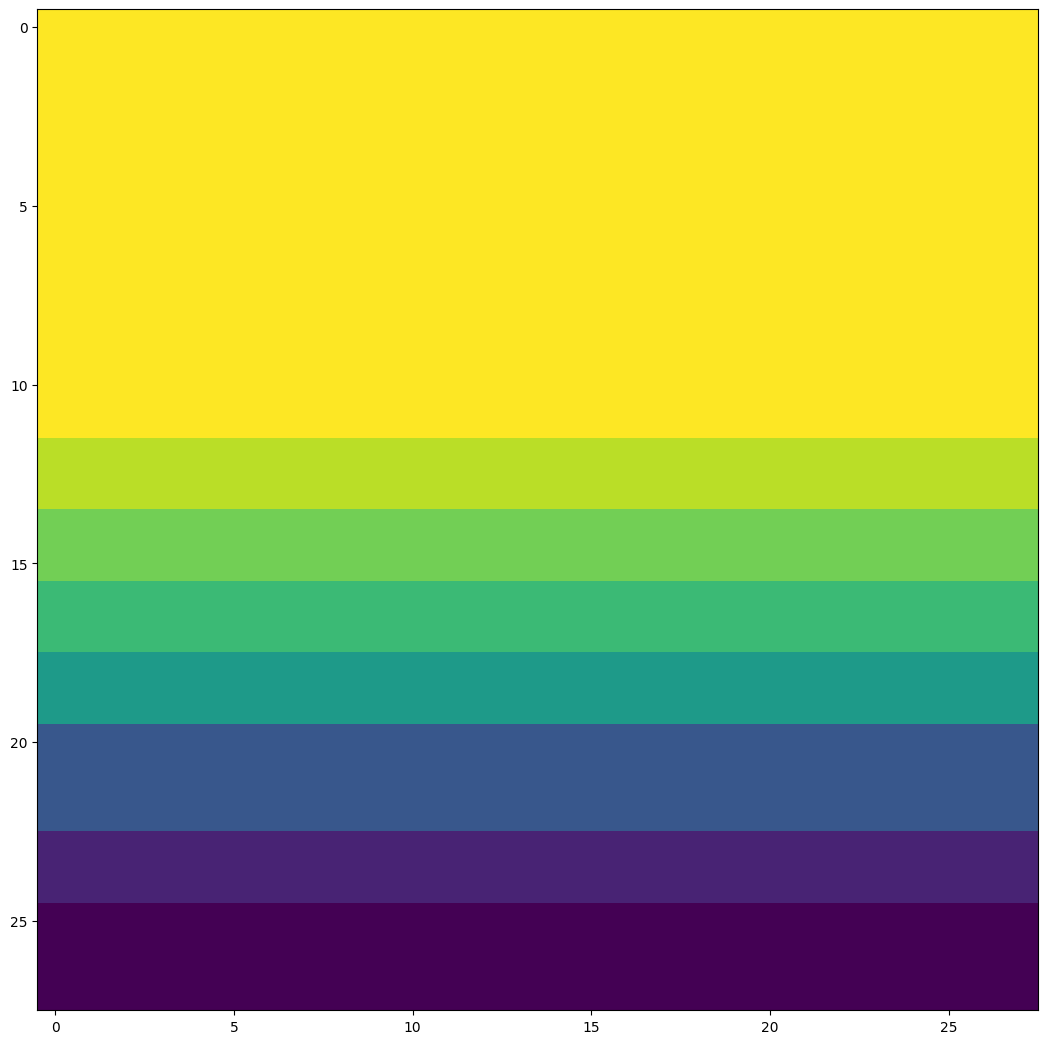

In [27]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(counts, cmap='viridis')

Text(0, 0.5, 'true time')

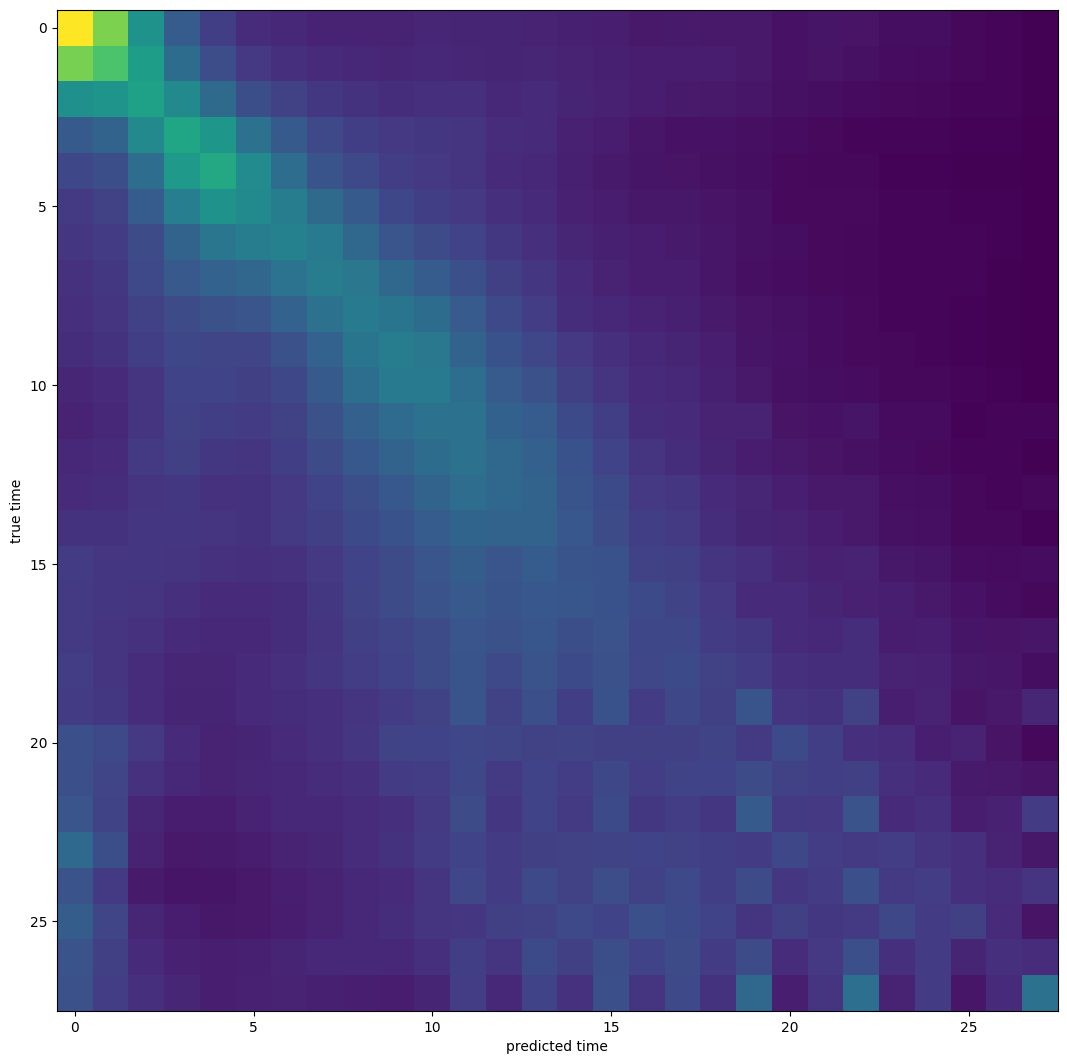

In [28]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs, cmap='viridis')
ax.set_xlabel('predicted time')
ax.set_ylabel('true time')

In [29]:
outputs[:5, :5]

array([[0.21387405, 0.17206091, 0.1111422 , 0.06354874, 0.04119461],
       [0.17045611, 0.15384128, 0.11962737, 0.07720544, 0.05201893],
       [0.10863931, 0.11159411, 0.12346836, 0.10238995, 0.07511837],
       [0.06167122, 0.06953499, 0.10203358, 0.12670563, 0.1141167 ],
       [0.04795824, 0.0526353 , 0.07805046, 0.11621552, 0.13023582]])

## scan parameters

In [30]:
N_scan = 5
for learning_rate_ in learning_rate*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, learning_rate=learning_rate_, verbose=False)
    print(f'learning_rate={learning_rate_:.3e}:{loss=:.3e}')

learning_rate=5.000e-06:loss=1.297e-01
learning_rate=1.581e-05:loss=1.295e-01
learning_rate=5.000e-05:loss=1.297e-01
learning_rate=1.581e-04:loss=1.307e-01
learning_rate=5.000e-04:loss=1.340e-01


In [31]:
for logit_0_ in logit_0*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_0=logit_0_, verbose=False)
    print(f'logit_0={logit_0_:.3e}:{loss=:.3e}')

logit_0=-2.000e-01:loss=1.297e-01
logit_0=-6.325e-01:loss=1.297e-01
logit_0=-2.000e+00:loss=1.297e-01
logit_0=-6.325e+00:loss=1.297e-01
logit_0=-2.000e+01:loss=1.297e-01


In [32]:
for logit_wt_ in logit_wt*np.logspace(-1, 1, N_scan, base=10):
    logistic_model, loss = fit_data(fr, logit_wt=logit_wt_, verbose=False)
    print(f'logit_wt={logit_wt_:.3e}:{loss=:.3e}')

logit_wt=1.000e-03:loss=1.297e-01
logit_wt=3.162e-03:loss=1.297e-01
logit_wt=1.000e-02:loss=1.297e-01
logit_wt=3.162e-02:loss=1.297e-01
logit_wt=1.000e-01:loss=1.297e-01


In [33]:
for beta1_ in 1-np.logspace(-2, -5, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta1=beta1_, verbose=False)
    print(f'beta1={beta1_:.3e}:{loss=:.3e}')

beta1=9.900e-01:loss=1.298e-01
beta1=9.982e-01:loss=1.295e-01
beta1=9.997e-01:loss=1.293e-01
beta1=9.999e-01:loss=1.532e-01
beta1=1.000e+00:loss=1.532e-01


In [34]:
for beta2_ in 1-np.logspace(-1, -4, N_scan, base=10):
    logistic_model, loss = fit_data(fr, beta2=beta2_, verbose=False)
    print(f'beta2={beta2_:.3e}:{loss=:.3e}')

beta2=9.000e-01:loss=2.284e-01
beta2=9.822e-01:loss=1.298e-01
beta2=9.968e-01:loss=1.297e-01
beta2=9.994e-01:loss=1.297e-01
beta2=9.999e-01:loss=1.297e-01


In [35]:
logistic_model, loss = fit_data(fr, amsgrad=not(amsgrad), verbose=False)
print(f'amsgrad={not(amsgrad)}:{loss=:.3e}')

amsgrad=True:loss=1.296e-01
